# MSIN0114 Dissertaion - Hybrid Recommendation System for Startup E-commerce


This is the code of the hybrid recommendation system for Green Wallet, which includes data cleaning,explanatory data analysis, feature engineering, model building and evaluation respectively. 


In [3]:
# install the relevant packages 
#% pip install surprise
#% pip install reader
#% pip install plotly==5.1.0.

     |████████████████████████████████| 11.8 MB 5.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619404 sha256=146d6d1547fe7e36181dc2b8f9f6f33777bd0e2aa2d2f2fa43cb3cef6936905a
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [5]:
#% pip install plotly 
#pip install cufflinks 
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [32]:
# Load spacy model (with fallback for Google Colab)
import spacy
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    import spacy.cli 
    print("Model not found. Downloading.")
    spacy.cli.download("en_core_web_md")
    import en_core_web_md
    nlp = en_core_web_md.load()

Model not found. Downloading.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [4]:
# import necessary modules
import pandas as pd
import numpy as np
import seaborn  as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
import string
from random import choice
import random
from textblob import TextBlob
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import KNNWithZScore
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import accuracy
from surprise import Reader
from surprise import Dataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from collections import defaultdict
from sklearn.model_selection import train_test_split
from surprise.model_selection import cross_validate

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Data Preparation for Model

This section is corresponding to section 3.1.2 data cleaning of the report which prepares two datasets, namely product and user ratings. 


In [45]:
product = pd.read_csv("/content/drive/MyDrive/UCL Dissertaion ---  Green Wallet/ananke_public_products.csv")
shipment = pd.read_csv("/content/drive/MyDrive/UCL Dissertaion ---  Green Wallet/ananke_public_product_shipments.csv",header = None)
users = pd.read_csv("/content/drive/MyDrive/UCL Dissertaion ---  Green Wallet/nemesis_public_wallet_accounts.csv",header = None)
reviews = pd.read_csv("/content/drive/MyDrive/UCL Dissertaion ---  Green Wallet/ananke_public_product_reviews.csv")

In [ ]:
# load the product dataset
product = pd.read_csv("/Users/changyin/Desktop/UCL DISSERTATION/GW  data/ananke/ananke_public_products.csv")

In [ ]:
# load the shipment dataset
shipment = pd.read_csv("/Users/changyin/Desktop/UCL DISSERTATION/GW  data/ananke/ananke_public_product_shipments.csv",header = None)

In [ ]:
# load the user dataset
users = pd.read_csv("/Users/changyin/Desktop/UCL DISSERTATION/GW  data/nemesis/nemesis_public_wallet_accounts.csv",header = None)

In [ ]:
# load the review dataset
reviews = pd.read_csv("/Users/changyin/Desktop/UCL DISSERTATION/GW  data/ananke/ananke_public_product_reviews.csv")

In [46]:
# set the column name for shipment
shipment.columns = ['shipment_id', 'product_id','merchant_id','method','delivery_time','amount','currency','vat','threshold','title']

In [47]:
# set the column name for user
users.columns = ['id','user_id','email']

In [48]:
# select the relevant column for product
product = product.iloc[:,:6]

In [49]:
# drop the missing value for product
product = product.dropna().reset_index()

In [50]:
# drop the duplicated values for product
product.drop_duplicates(subset ="product_name",
                     keep = False, inplace = True)

In [51]:
# reset index
product = product.reset_index()

In [52]:
# create a new dataframe combining product id and product name
product_id_name= product[['product_id','product_name']]

In [53]:
# create a new dataframe combining product id and product details 
product_descp = product[['product_id','product_details']]

In [54]:
# drop the missing value for product details
product_descp = product_descp.dropna()

In [55]:
# simualte users for shipment dataset
shipment['user_id']=0
for i in range(len(shipment)):
    shipment['user_id'][i] = choice(users['user_id'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [56]:
# create an order dataframe by including product id and user id
order = shipment[['product_id','user_id']]

In [57]:
# simulate ratings for the order
order['rating'] = 0 
for i in range(len(order)):
    order['rating'][i] = int(random.choices([1,2,3,4,5], weights=[1,1,2,13,17], k=1)[0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

## 2. Exploratory Data Analysis

This part corresponds to section 3.1.4 data visualization of the report which includes product dataset and review ratings.


### 2.1 Product Dataset Analysis

In [58]:
product['detail_len'] = product['product_details'].astype(str).apply(len)
product['word_count'] = product['product_details'].apply(lambda x: len(str(x).split()))

In [ ]:
product['detail_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='character count',
    linecolor='black',
    yTitle='count',
    title='Character Count Distribution')

In [ ]:
product['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

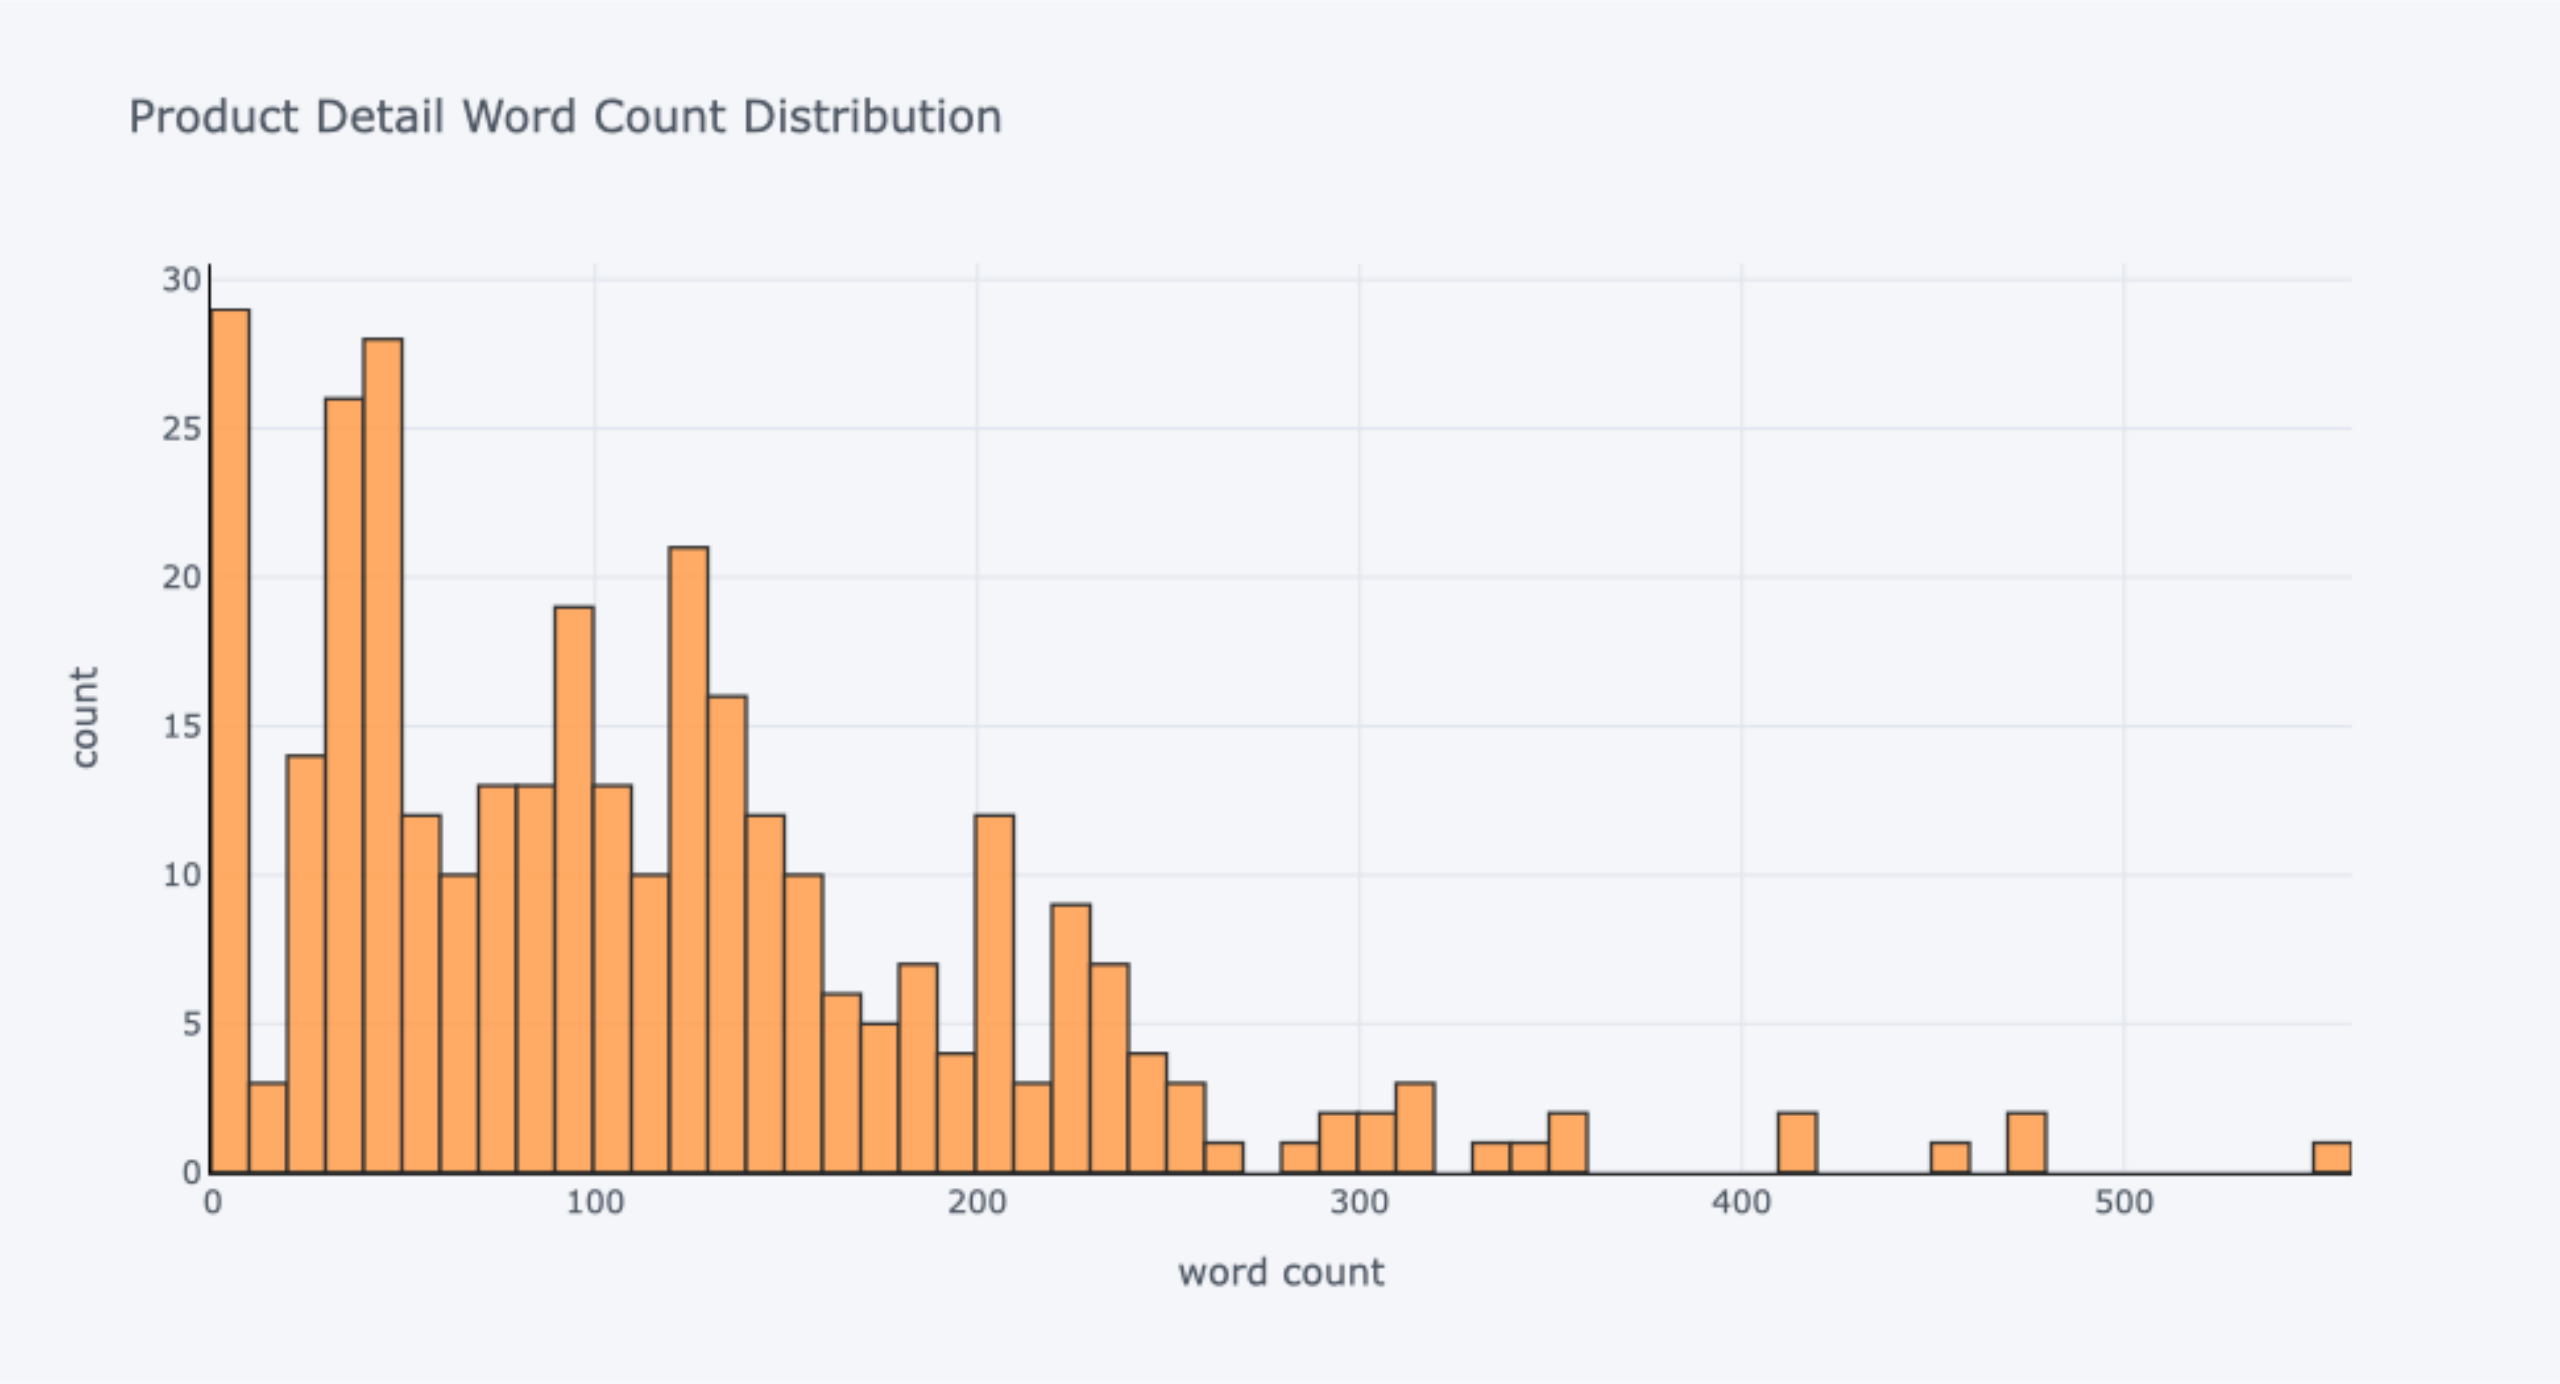

In [ ]:
product.groupby('product_category').count()['product_id'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', opacity=0.8,
                                                           title='Bar chart of Category', xTitle='Category')

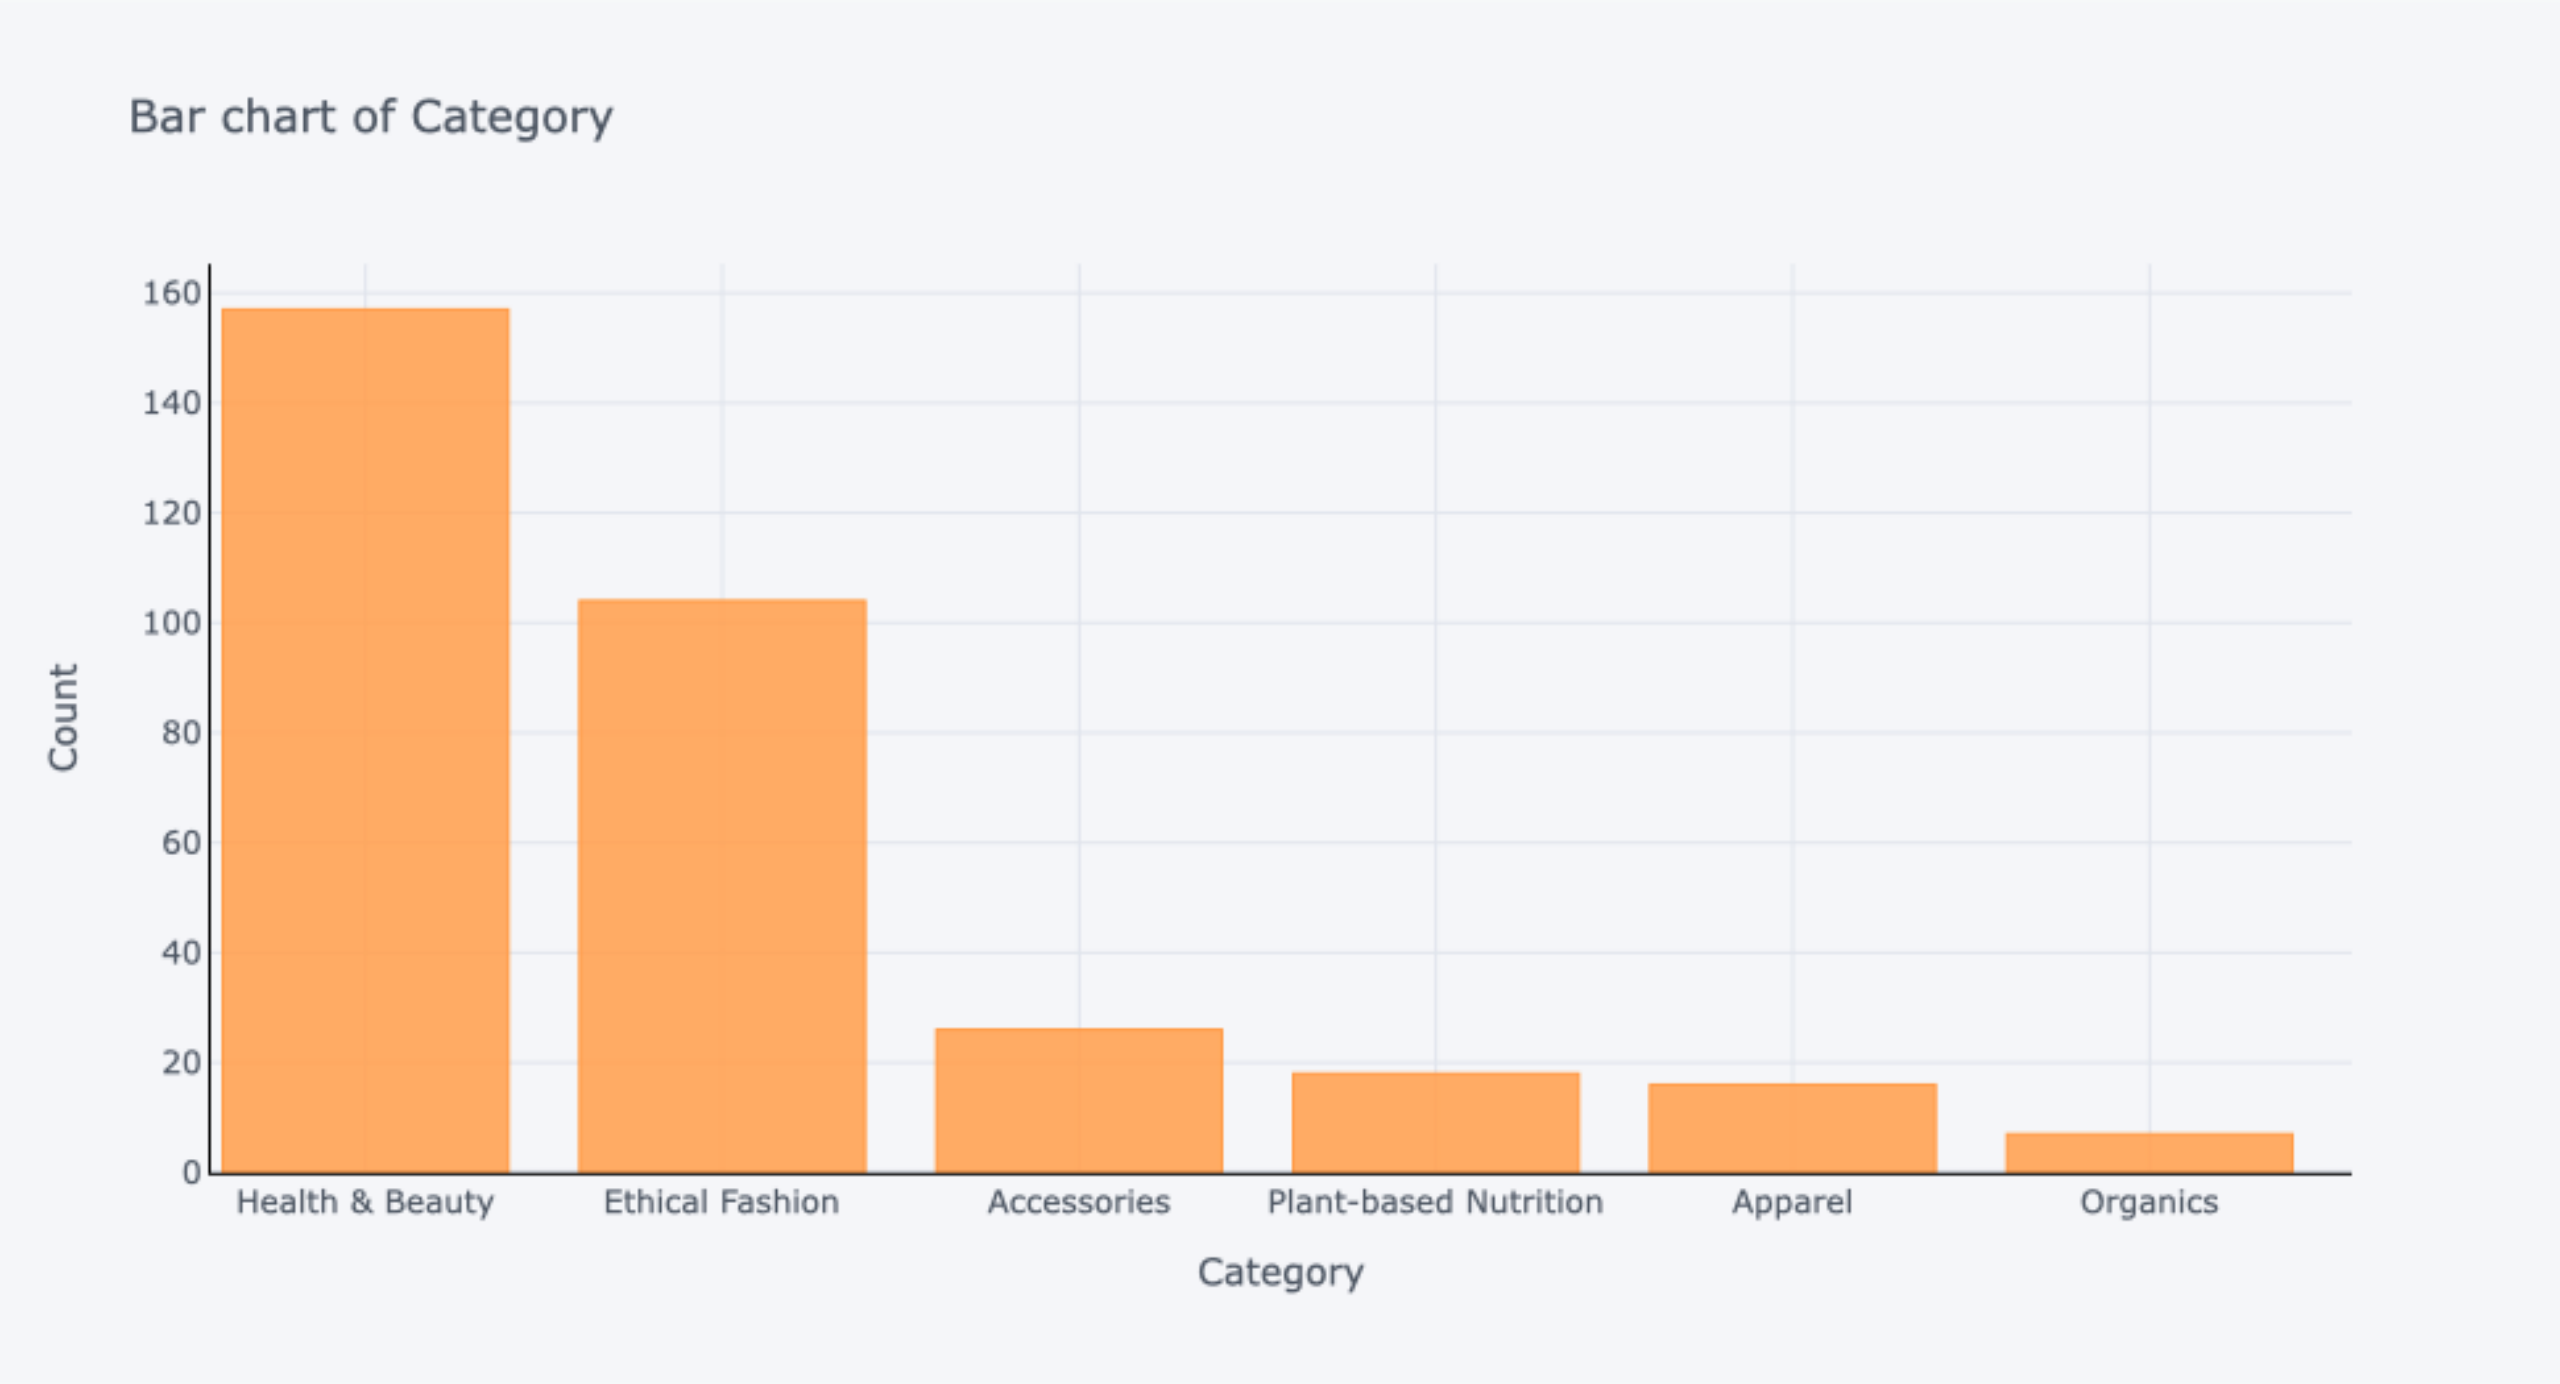

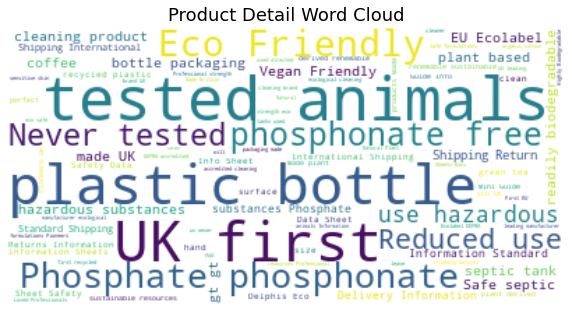

In [29]:
# Generate word cloud for stree and non-stress posts

product_sample=" ".join(i for i in product['product_details'])

# Generate the image
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=100).generate(product_sample)

# visualize the image
fig=plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Product Detail Word Cloud', size=18)
plt.show()

print("\n")



### 2.2 Review Dataset Analysis

In [ ]:
reviews['rating'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')

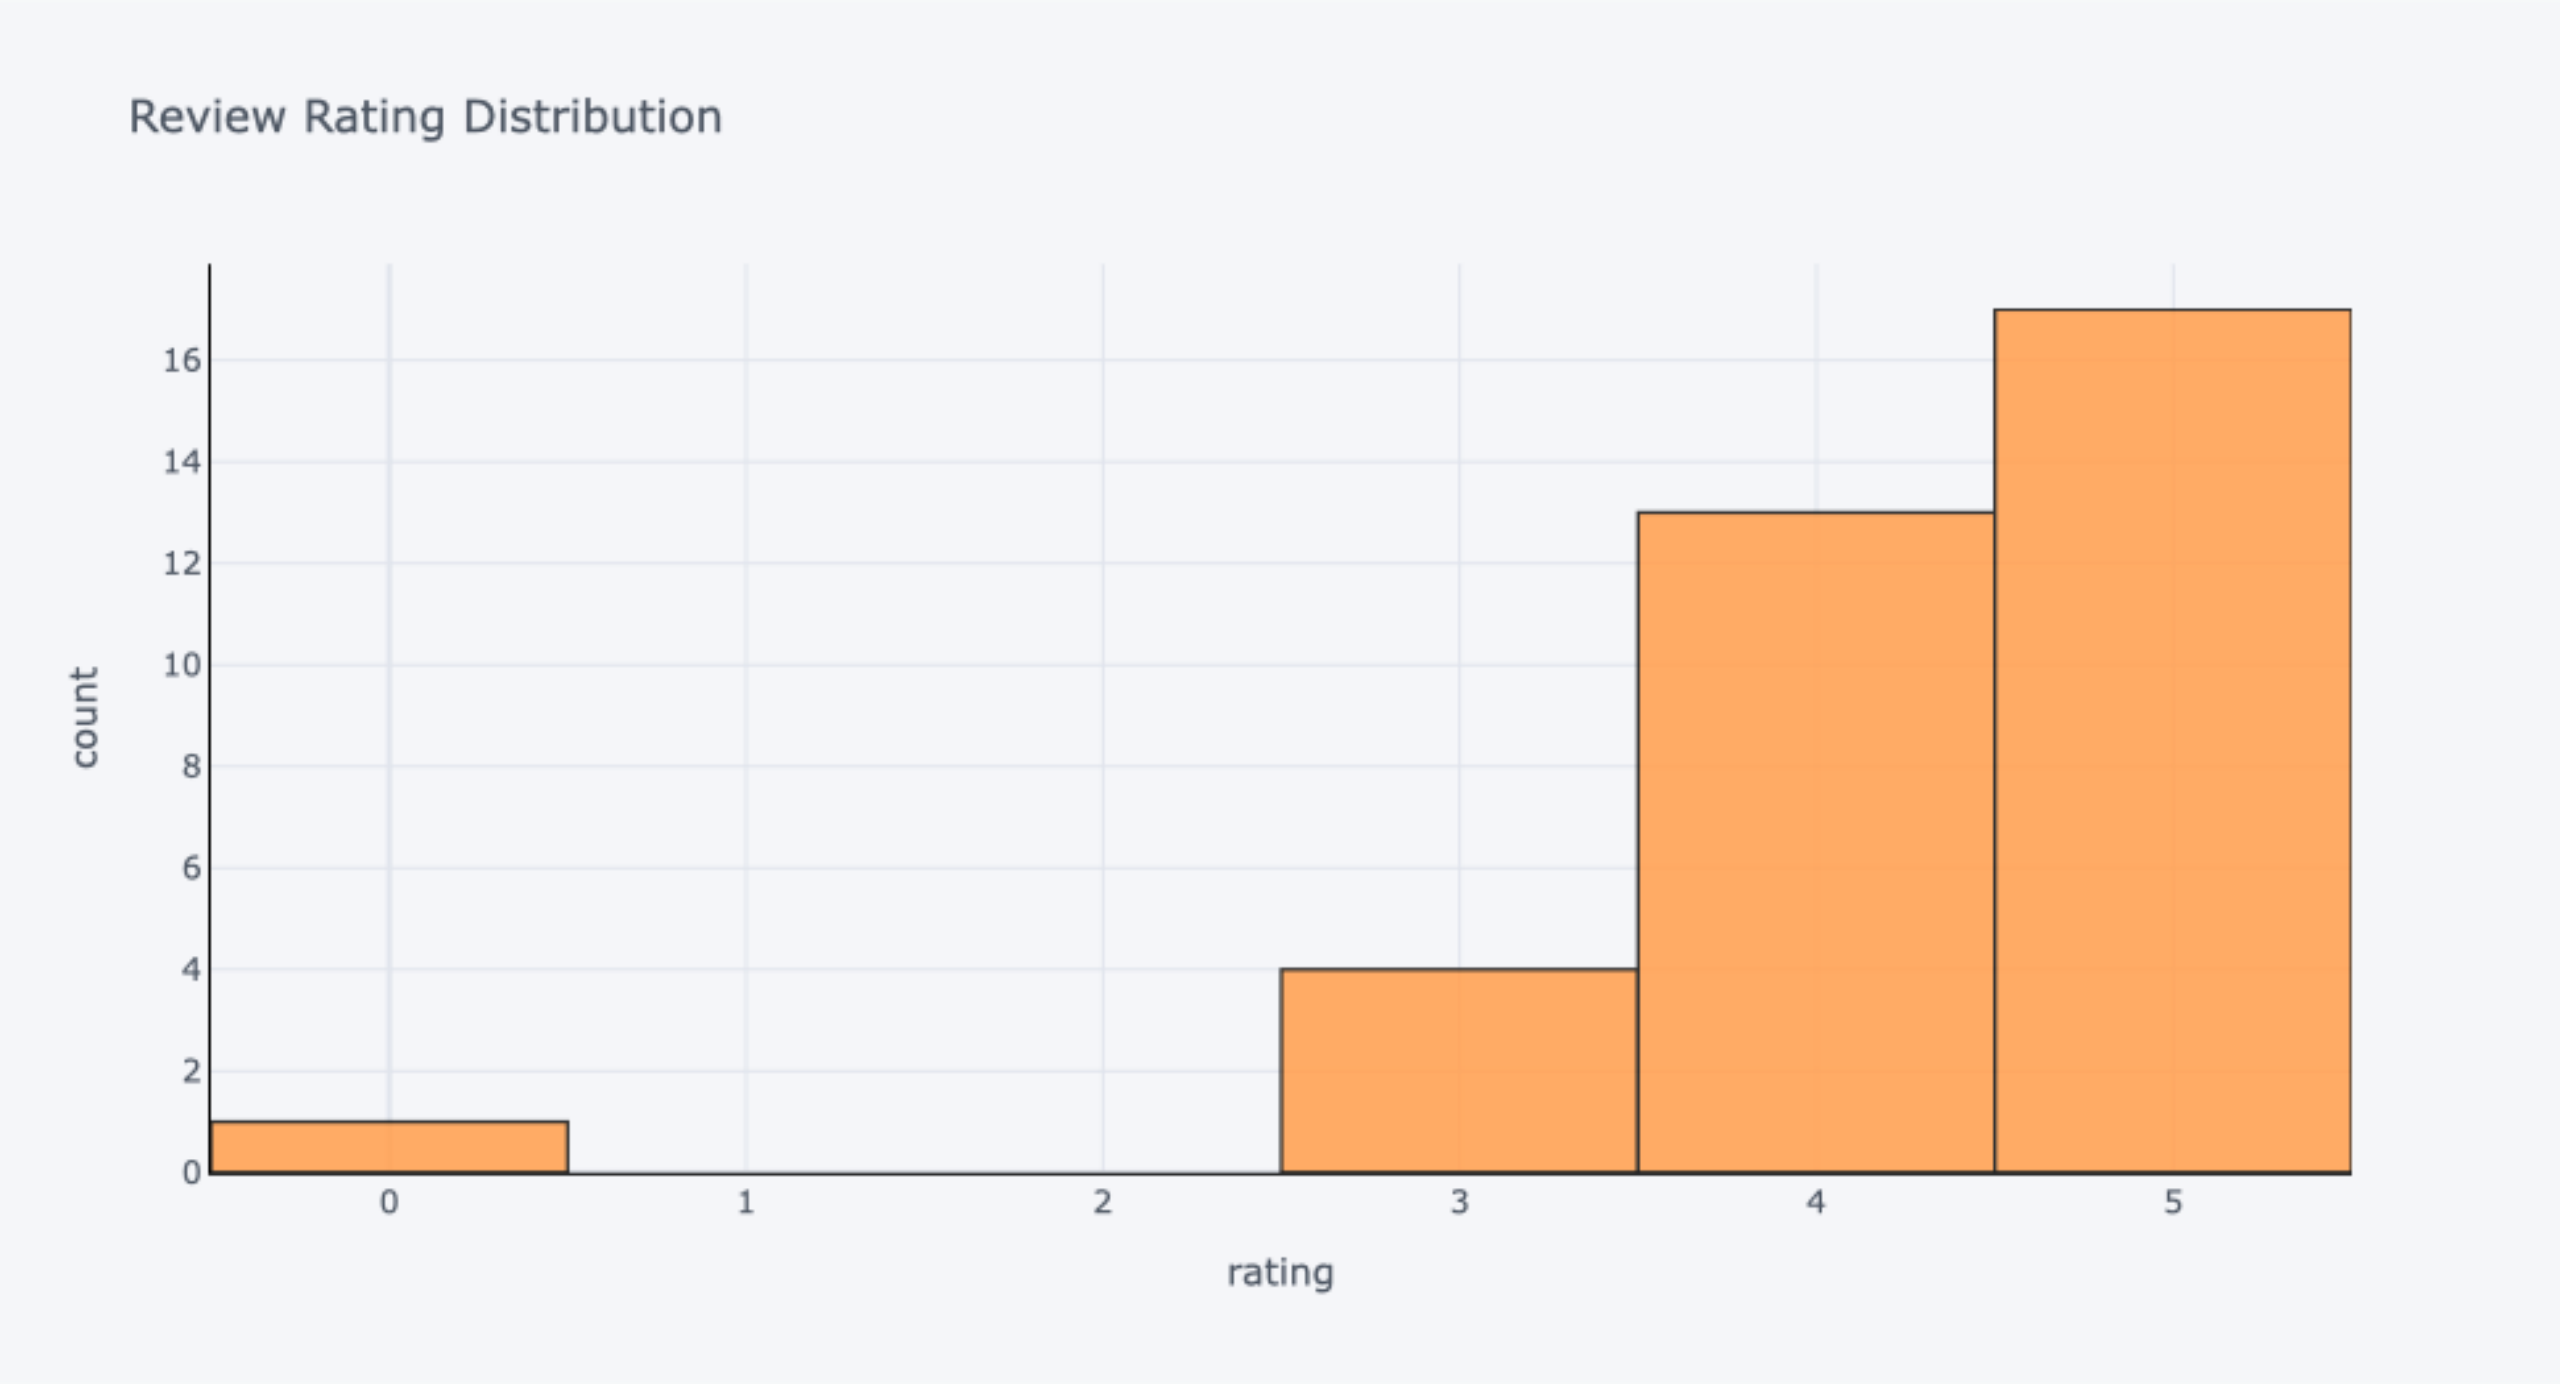

In [25]:
# this is the function to cleant the text of the reviews
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
reviews['review_detail'] = preprocess(reviews['review_detail'])

reviews['polarity'] = reviews['review_detail'].map(lambda text: TextBlob(text).sentiment.polarity)
reviews['review_len'] = reviews['review_detail'].astype(str).apply(len)
reviews['word_count'] = reviews['review_detail'].apply(lambda x: len(str(x).split()))

In [ ]:
reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

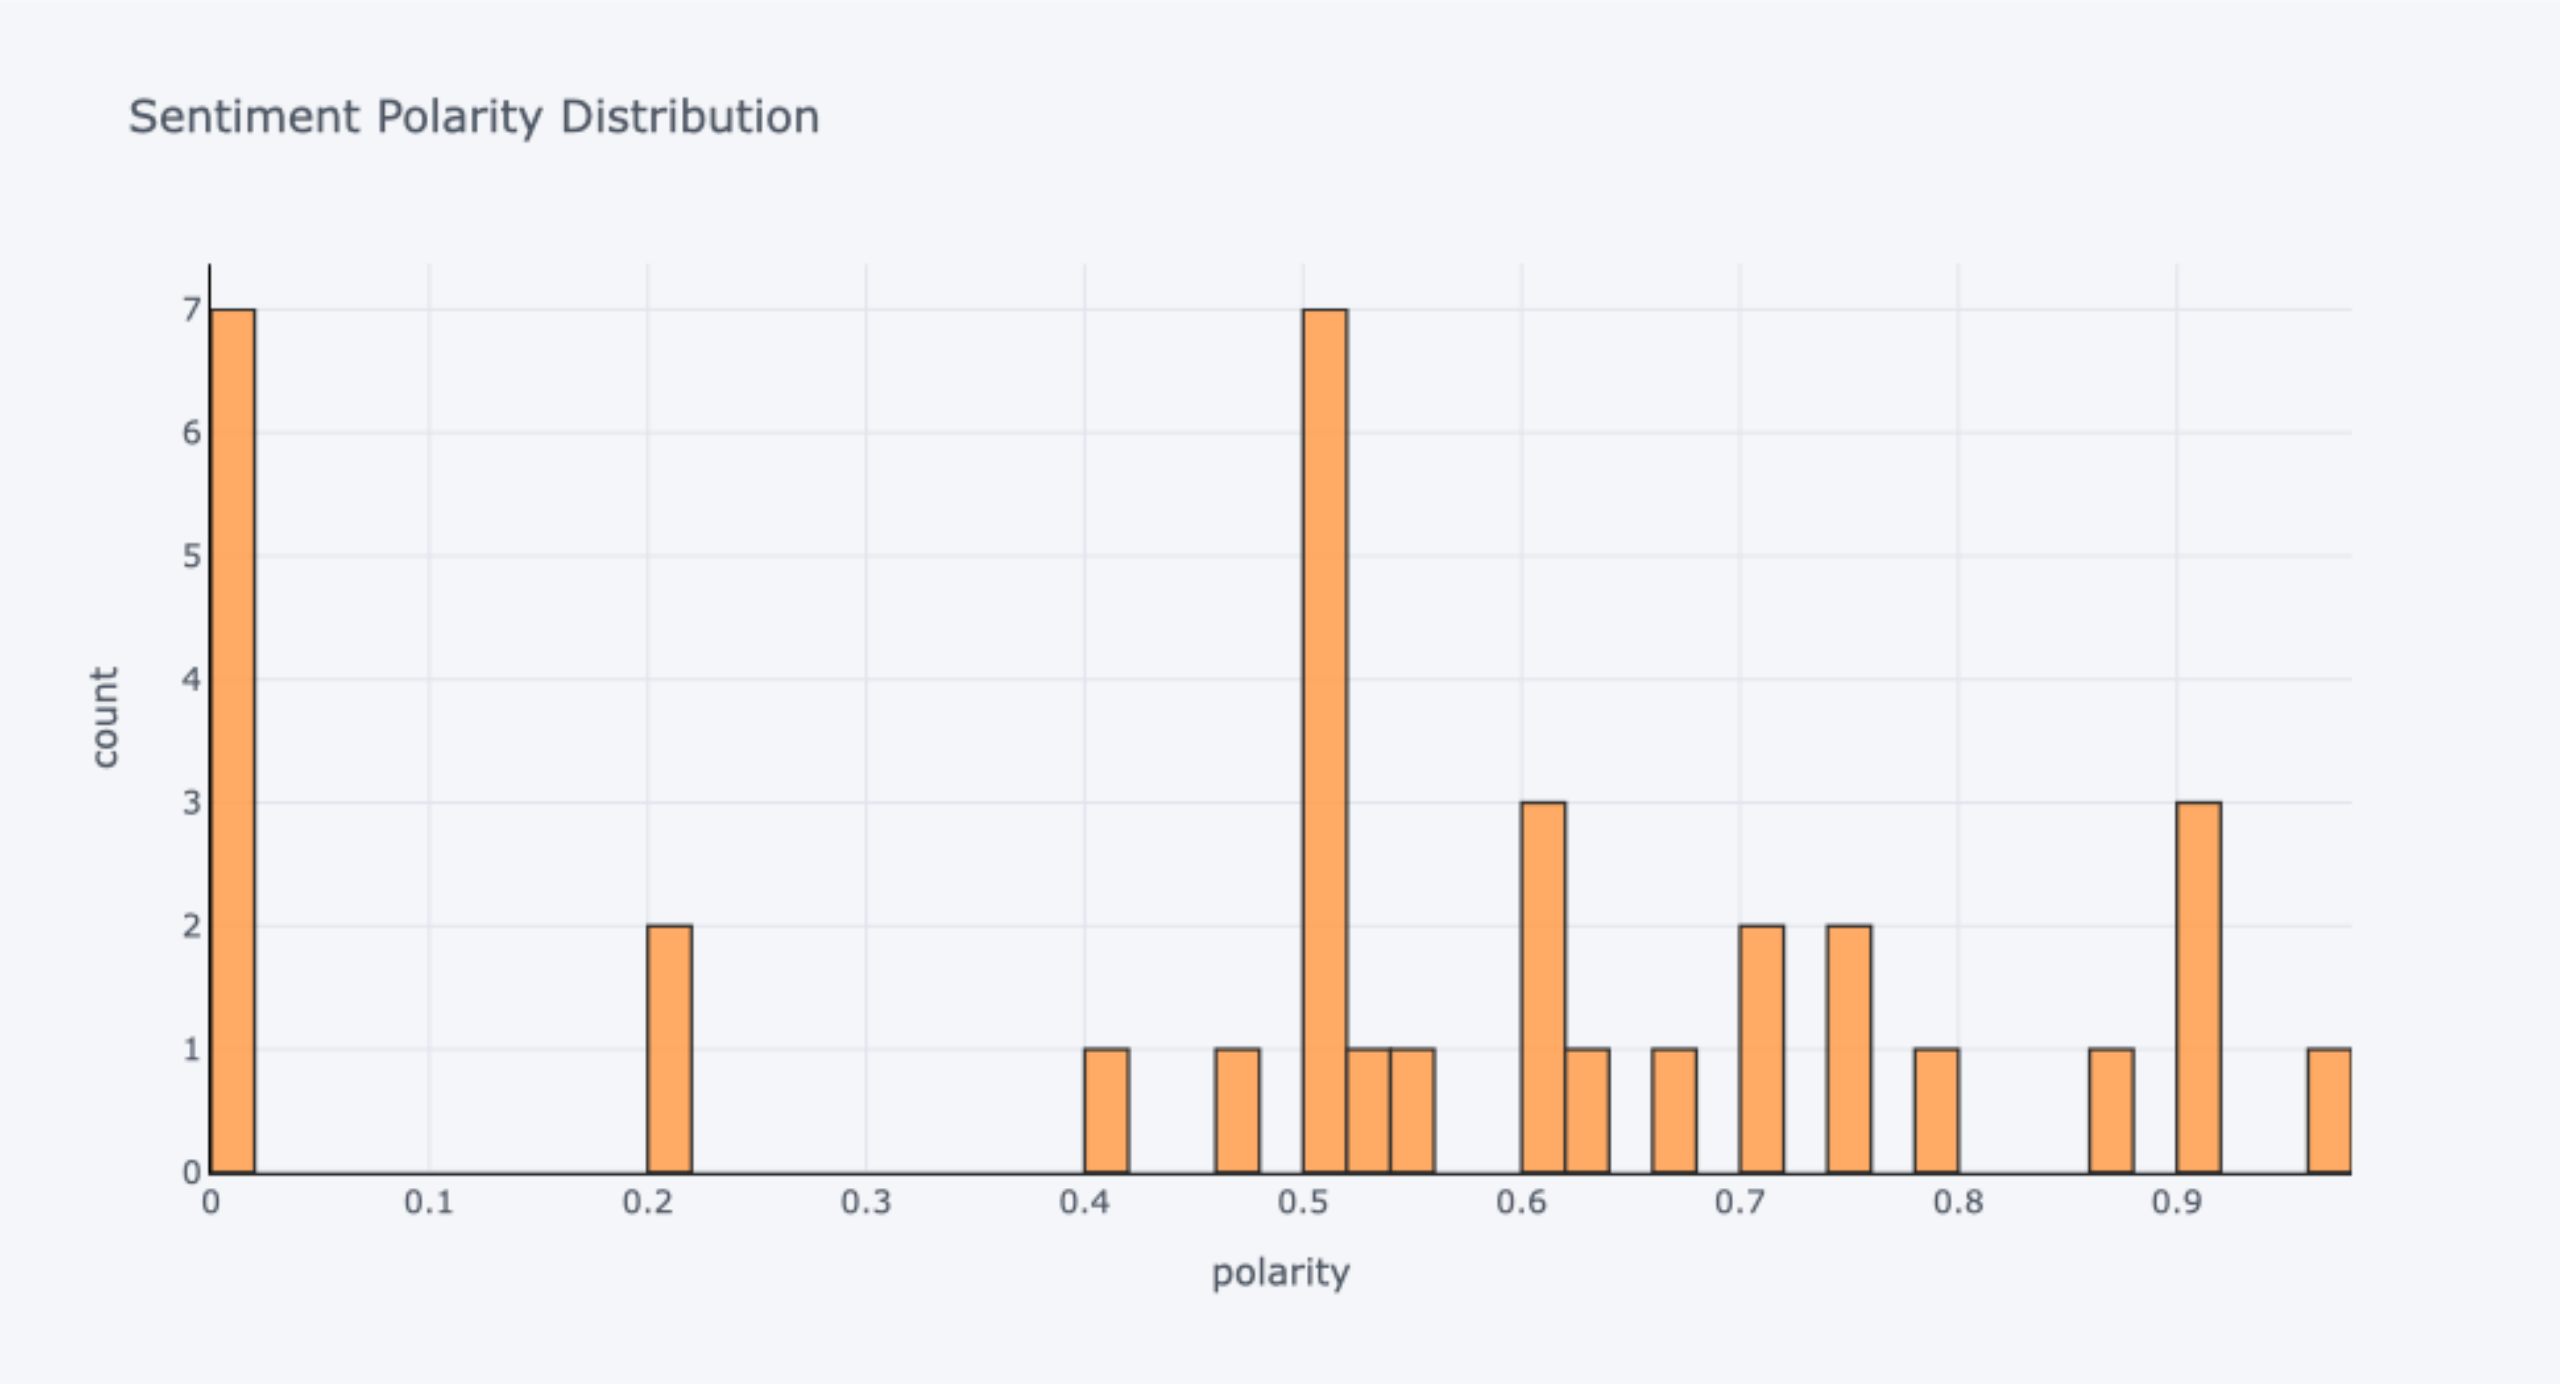

In [ ]:
reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

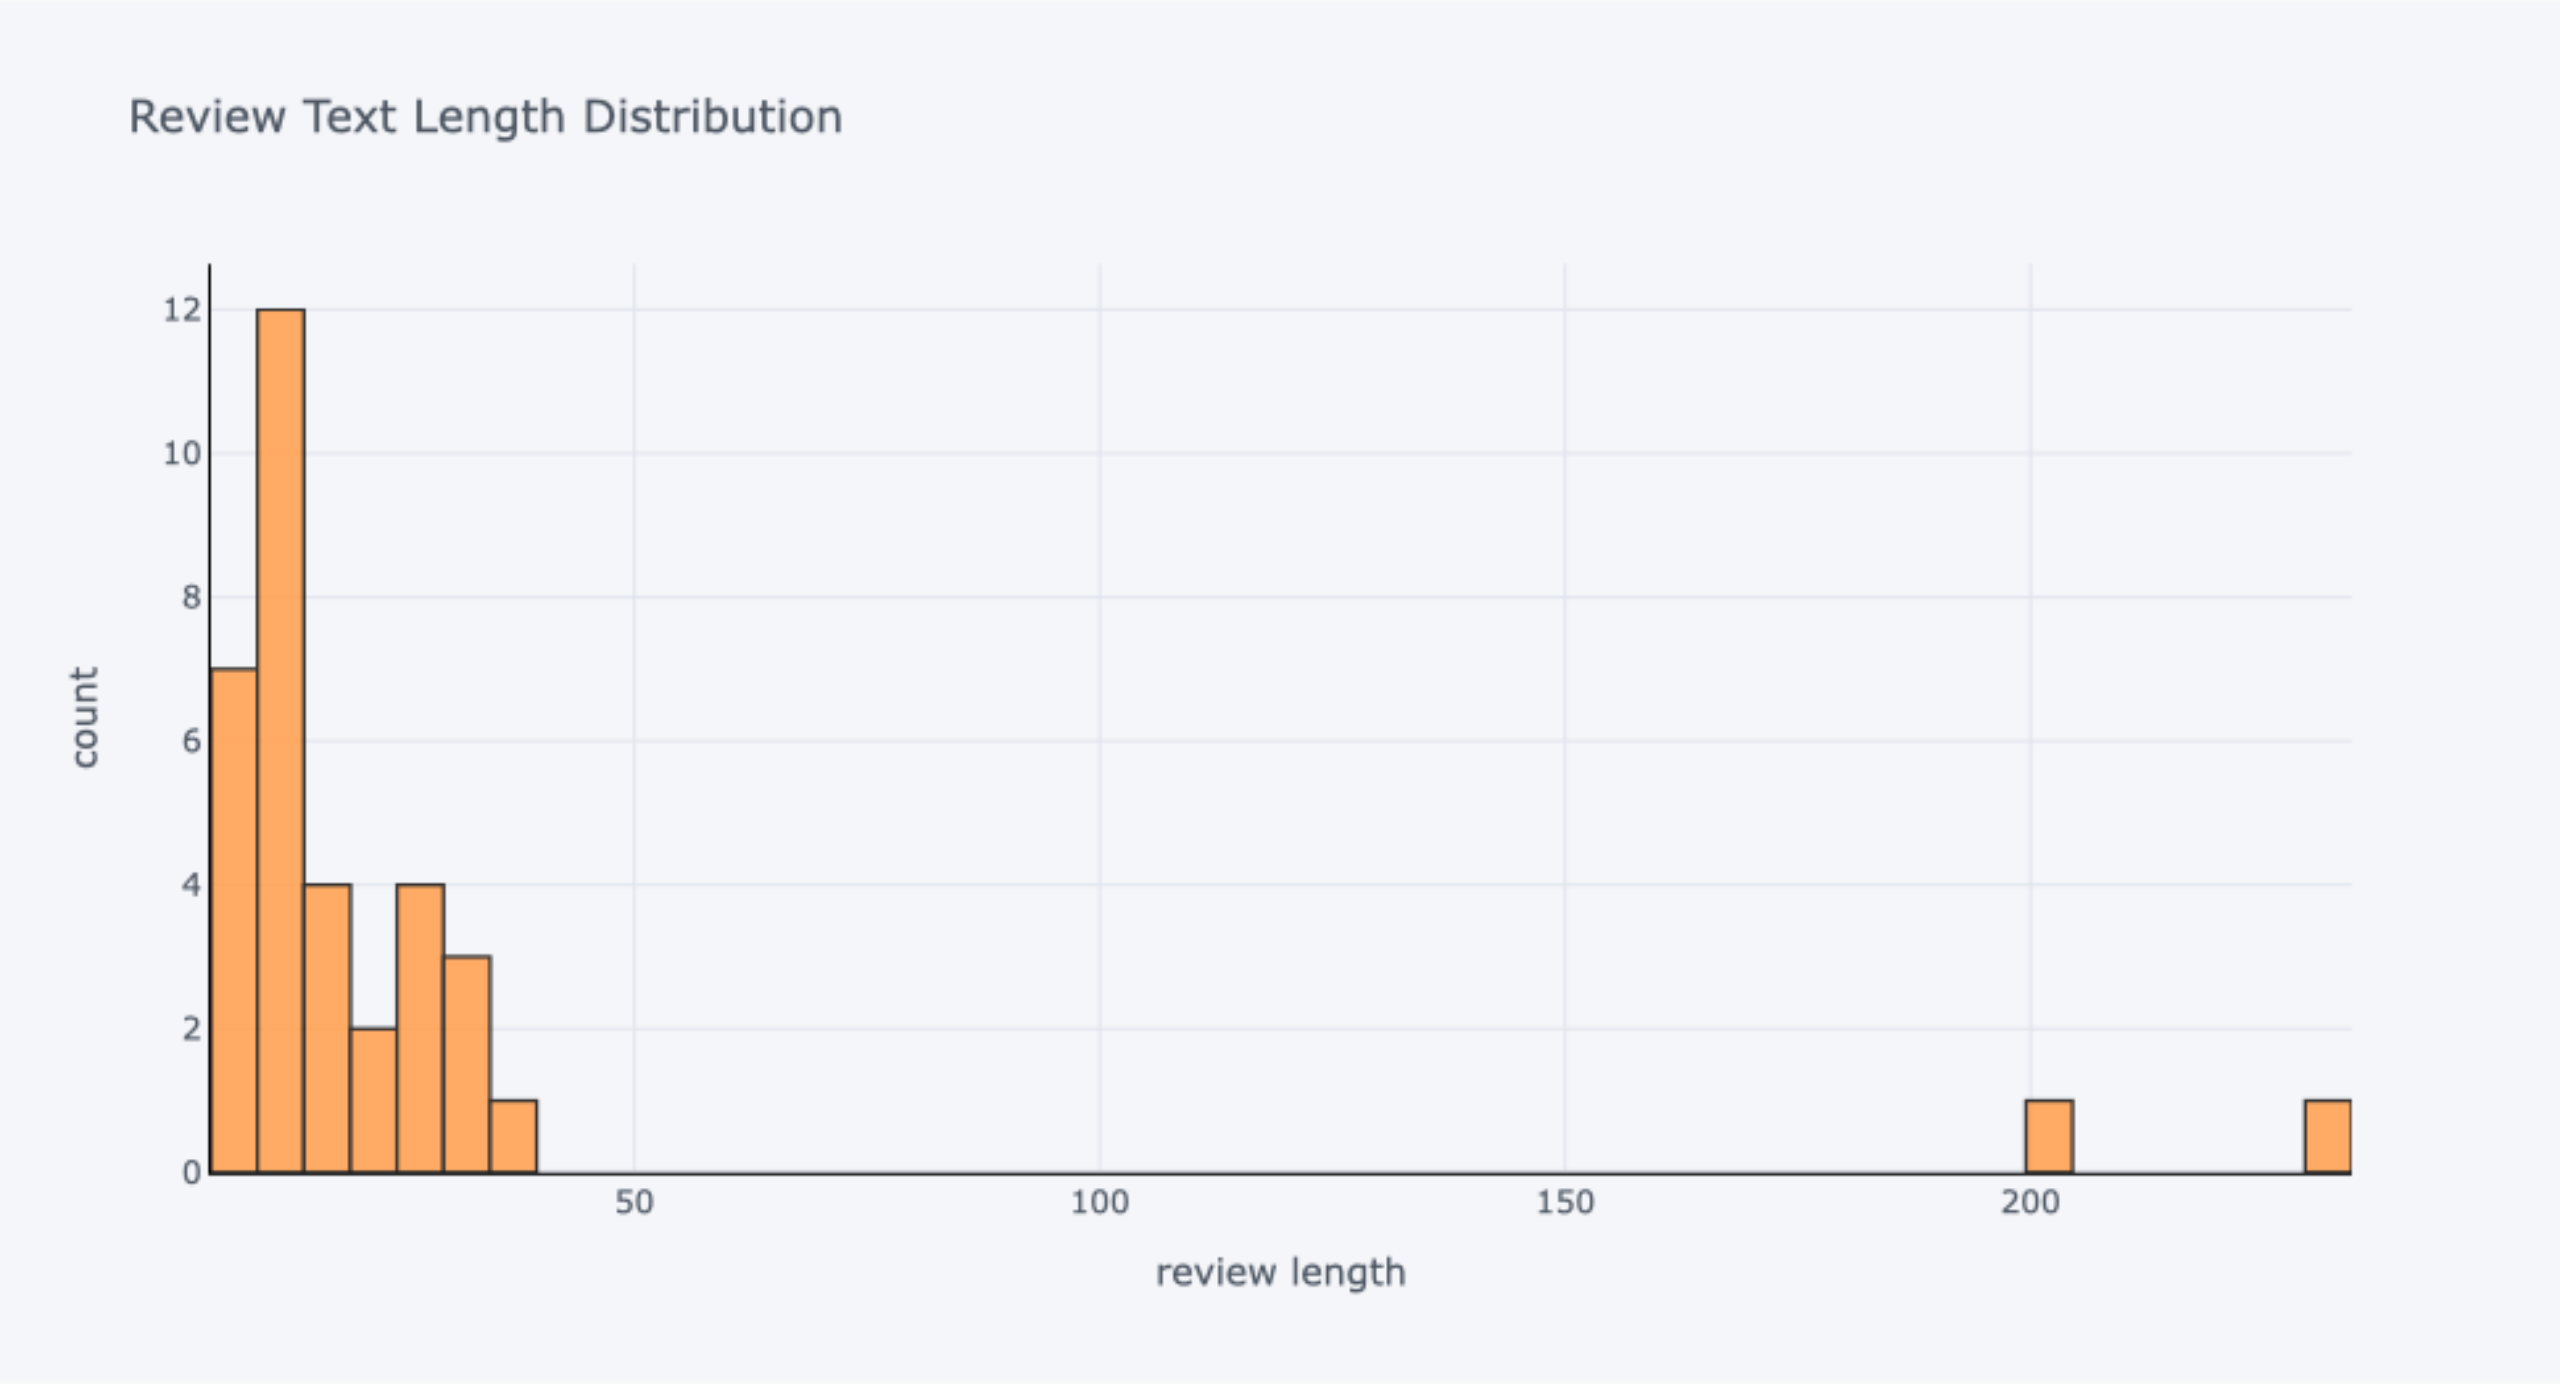

## 3. Model Building 

### 3.1 Content-Based Recommendation System 
### 3.1.1 Feature Weighting Method

In [60]:
# define a function to match index and product_id
def index_match(product_id):
    return product_id_name[product_id_name['product_id']==product_id].index.values[0]

In [61]:
# define a function to calcalate similarity score by using product features such as product categoty, brand and price range.
def similarity_score(product_id,topn):
    index = index_match(product_id)
    encoder1 = OneHotEncoder()
    encoder2 = OneHotEncoder()
    cat_1 = product[["product_category"]]
    cat_2 = product[["product_brand"]]
    cat_1hot = encoder1.fit_transform(cat_1).toarray()
    cat_2hot = encoder2.fit_transform(cat_2).toarray()
    type_matrix1 = np.matmul(cat_1hot,np.matrix.transpose(cat_1hot))
    type_matrix2 = np.matmul(cat_2hot,np.matrix.transpose(cat_2hot))
    score = type_matrix1*2+type_matrix2*1
    score_dict = dict(zip(np.arange(0,len(score[0]),1),list(score[index])))
    sorted_dict = dict(sorted(score_dict.items(), key=lambda item: item[1],reverse=True)[:topn])
    result_index = list(sorted_dict.keys())  
    return list(product_id_name.iloc[x] for x in result_index)

In [62]:
# example
product_id_name.iloc[index_match('64c7e6c5-379d-479a-9885-7c4eb98e8290')]

product_id      64c7e6c5-379d-479a-9885-7c4eb98e8290
product_name                         Xfactor Cleaner
Name: 327, dtype: object

In [63]:
# return top 5 similar products
similarity_score('64c7e6c5-379d-479a-9885-7c4eb98e8290',5)

[product_id      da95fc06-3d59-473b-9c70-a4fa5e4a6eef
 product_name                        Washroom Cleaner
 Name: 4, dtype: object,
 product_id         16be2778-f8cf-452d-8e49-daab3a6fe332
 product_name    Washroom Cleaner Refill Bottle 750ml **
 Name: 5, dtype: object,
 product_id      4367cdcb-37af-42b4-a8ae-6dbc9d02f303
 product_name             Anti-Bacterial Foaming Soap
 Name: 7, dtype: object,
 product_id      b6ccc620-a6de-40ec-9f11-b48e3eb169d1
 product_name          Anti-Bacterial Hand Soap (RTU)
 Name: 9, dtype: object,
 product_id      18ce5967-791f-4bbd-a7ce-d1a87213eefb
 product_name     Anti-Bacterial Hand Soap Wash 350ml
 Name: 14, dtype: object]

### 3.1.2 Vector Space Model(VSM)

In [64]:
# define a function to clean the text of job description
def text_cleaning(text):
    text = ''.join(c for c in text if not c in string.punctuation)
    text = ''.join((x for x in text.lower() if not x.isdigit())) # remove numbers 
    text = " ".join([token.lemma_ for token in nlp(text)]) # lemmanisation 
    symbol = ['\n','\t','&lt','&gt','product','details','✓','-','gtgt','ltlt','pron']
    text = ''.join(c for c in text if not c in symbol)
    return text

In [65]:
# define a function 
for i in range(len(product_descp["product_details"])):
    product_descp.iloc[i,1] = text_cleaning(product_descp.iloc[i,1])

In [66]:
# define a function for keyword extraction
def key_word(corpus,topn):
    result = []
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)
    X = X.toarray()
    for i in range(X.shape[0]):
        X1 = X[i,:]
        dict1 = dict(zip(np.arange(0,len(X1),1),list(X1)))
        sorted_dict = dict(sorted(dict1.items(), key=lambda item: item[1],reverse=True)[:topn])
        result_index = list(sorted_dict.keys())
        feature_name = list(vectorizer.get_feature_names())
        result.append([feature_name[x] for x in result_index])
    return result

In [67]:
# choose top 10 keyword
result = key_word(product_descp['product_details'],10)

In [68]:
# define a function to calculate cosine similarity
def cosine_similarity(product_id,topn):
    index = index_match(product_id)
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf= vectorizer.fit_transform(product_descp['product_details'])
    cosine_similarities = linear_kernel(tfidf[index:index+1], tfidf).flatten()
    cosine_dict = dict(zip(np.arange(0,len(cosine_similarities),1),list(cosine_similarities)))
    sorted_dict = dict(sorted(cosine_dict.items(), key=lambda item: item[1],reverse=True)[1:topn+1])
    result_index = list(sorted_dict.keys())  
    return list(product_id_name.iloc[x] for x in result_index)

In [69]:
cosine_similarity('64c7e6c5-379d-479a-9885-7c4eb98e8290',5)

[product_id      f363cc89-0d33-48c5-ad96-b976280e74c8
 product_name                   Multi-Purpose Cleaner
 Name: 286, dtype: object, product_id      0a10b85f-525d-441b-a71b-62aea66a8b2a
 product_name                               Hand Soap
 Name: 264, dtype: object, product_id      33334898-9822-455f-8558-57edc5549bcc
 product_name                  Graffiti Remover Wipes
 Name: 258, dtype: object, product_id        75ee3f1a-cd9c-4e3c-95eb-f3227a818878
 product_name    Super Active Washing-Up Liquid (Conc.)
 Name: 301, dtype: object, product_id      29181a6f-d235-4577-b80f-f435cfb425c9
 product_name                         Descaler (Conc)
 Name: 56, dtype: object]

### 3.1.3 Combine Feature Weightings and Cosine Similarity

In [70]:
# create a class to combine the above methods
class content_based():
    def __init__(self,product_id,topn):
        self.product_id = product_id
        self.topn = topn
        self.index = index_match(product_id)
        encoder1 = OneHotEncoder()
        encoder2 = OneHotEncoder()
        cat_1 = product[["product_category"]]
        cat_2 = product[["product_brand"]]
        cat_1hot = encoder1.fit_transform(cat_1).toarray()
        cat_2hot = encoder2.fit_transform(cat_2).toarray()
        type_matrix1 = np.matmul(cat_1hot,np.matrix.transpose(cat_1hot))
        type_matrix2 = np.matmul(cat_2hot,np.matrix.transpose(cat_2hot))
        self.score1 = type_matrix1*2+type_matrix2*1
        vectorizer = TfidfVectorizer(stop_words='english')
        tfidf= vectorizer.fit_transform(product_descp['product_details'])
        self.score2 = linear_kernel(tfidf[self.index:self.index+1], tfidf).flatten()
    def feature_weighting(self):
        score_dict = dict(zip(np.arange(0,len(self.score1[0]),1),list(self.score1[self.index])))
        sorted_dict = dict(sorted(score_dict.items(), key=lambda item: item[1],reverse=True)[:self.topn])
        result_index = list(sorted_dict.keys())  
        return list(product_id_name.iloc[x] for x in result_index)

    def cosine_similarity(self):
        cosine_dict = dict(zip(np.arange(0,len(self.score2),1),list(self.score2)))
        sorted_dict2 = dict(sorted(cosine_dict.items(), key=lambda item: item[1],reverse=True)[1:self.topn+1])
        result_index2 = list(sorted_dict2.keys())  
        return list(product_id_name.iloc[x] for x in result_index2)
  
    def combined_recommend(self):
        combined_socre = self.score1[self.index]/3*0.5+self.score2*0.5
        cosine_dict = dict(zip(np.arange(0,len(combined_socre),1),list(combined_socre)))
        sorted_dict = dict(sorted(cosine_dict.items(), key=lambda item: item[1],reverse=True)[1:self.topn+1])
        result_index = list(sorted_dict.keys())  
        return list(product_id_name.iloc[x] for x in result_index)

In [71]:
# try a example
r1 = content_based('64c7e6c5-379d-479a-9885-7c4eb98e8290',5)

In [72]:
r1.feature_weighting()

[product_id      da95fc06-3d59-473b-9c70-a4fa5e4a6eef
 product_name                        Washroom Cleaner
 Name: 4, dtype: object,
 product_id         16be2778-f8cf-452d-8e49-daab3a6fe332
 product_name    Washroom Cleaner Refill Bottle 750ml **
 Name: 5, dtype: object,
 product_id      4367cdcb-37af-42b4-a8ae-6dbc9d02f303
 product_name             Anti-Bacterial Foaming Soap
 Name: 7, dtype: object,
 product_id      b6ccc620-a6de-40ec-9f11-b48e3eb169d1
 product_name          Anti-Bacterial Hand Soap (RTU)
 Name: 9, dtype: object,
 product_id      18ce5967-791f-4bbd-a7ce-d1a87213eefb
 product_name     Anti-Bacterial Hand Soap Wash 350ml
 Name: 14, dtype: object]

In [73]:
r1.cosine_similarity()

[product_id      f363cc89-0d33-48c5-ad96-b976280e74c8
 product_name                   Multi-Purpose Cleaner
 Name: 286, dtype: object, product_id      0a10b85f-525d-441b-a71b-62aea66a8b2a
 product_name                               Hand Soap
 Name: 264, dtype: object, product_id      33334898-9822-455f-8558-57edc5549bcc
 product_name                  Graffiti Remover Wipes
 Name: 258, dtype: object, product_id        75ee3f1a-cd9c-4e3c-95eb-f3227a818878
 product_name    Super Active Washing-Up Liquid (Conc.)
 Name: 301, dtype: object, product_id      29181a6f-d235-4577-b80f-f435cfb425c9
 product_name                         Descaler (Conc)
 Name: 56, dtype: object]

In [74]:
r1.combined_recommend()

[product_id      f363cc89-0d33-48c5-ad96-b976280e74c8
 product_name                   Multi-Purpose Cleaner
 Name: 286, dtype: object, product_id      0a10b85f-525d-441b-a71b-62aea66a8b2a
 product_name                               Hand Soap
 Name: 264, dtype: object, product_id      33334898-9822-455f-8558-57edc5549bcc
 product_name                  Graffiti Remover Wipes
 Name: 258, dtype: object, product_id        75ee3f1a-cd9c-4e3c-95eb-f3227a818878
 product_name    Super Active Washing-Up Liquid (Conc.)
 Name: 301, dtype: object, product_id      29181a6f-d235-4577-b80f-f435cfb425c9
 product_name                         Descaler (Conc)
 Name: 56, dtype: object]

### 3.2 Model Based Collaborative Filtering

In [75]:
# define a function for model based collaborative filtering
def model_based(user_id,no_of_product):
  index = users[users['user_id']==user_id].index[0]
  ratings_utility_matrix = order.pivot_table(values='rating', index='user_id', columns='product_id', fill_value=0,aggfunc='first')
  X = ratings_utility_matrix.T
  from sklearn.decomposition import TruncatedSVD
  SVD = TruncatedSVD(n_components=10)
  decomposed_matrix = SVD.fit_transform(X)
  correlation_matrix = np.corrcoef(decomposed_matrix)
  correlation_product_ID = correlation_matrix[index]
  Recommend = list(X.index[correlation_product_ID > 0.90])
  index = [index_match(x) for x in Recommend[0:no_of_product]]
  return [product_id_name.iloc[x] for x in index]

In [76]:
# example
model_based('n001bs16rKgPIK0x',5)

[product_id      046c6fd4-fb76-40dd-8f80-7963ab983542
 product_name                         Kulson Low Tops
 Name: 127, dtype: object]

## 3.3 Hybrid Approach

In [77]:
# define a function to create the hybrid recommendation system
def hybrid(user_id,product_id,n_p):
    if (user_id in list(users['user_id'])):
        return model_based(user_id,n_p)
    else:
        r1 = content_based(product_id,n_p)
        return r1.combined_recommend()

In [78]:
# define a function to create the hybrid recommendation system
def hybrid1(user_id,product_id,n_p):
    if (user_id in list(users['user_id'])):
        result =  model_based(user_id,n_p)
        l1 = len(result)
        r1 = content_based(product_id,10-l1)
        result.append(r1.combined_recommend())
        return result
    else:
        r1 = content_based(product_id,n_p)
        return r1.combined_recommend()

In [81]:
hybrid1('n001bs16rKgPIK0x','02e3bf8f-57cd-4416-97e9-1fe5b4eef872',10)

[product_id      046c6fd4-fb76-40dd-8f80-7963ab983542
 product_name                         Kulson Low Tops
 Name: 127, dtype: object,
 [product_id             fbfdf872-8cd9-4767-9905-879512cc5845
  product_name    booheads - Bamboo Electric Toothbrush Heads
  Name: 242, dtype: object,
  product_id      fb793932-5bcf-4a17-93fc-6003879cd8da
  product_name      2-In-1 Solid Shampoo - Itchy Scalp
  Name: 247, dtype: object,
  product_id      5969917a-743e-4a8c-9311-ee15260186e5
  product_name            Seaweed Collagen Moisturiser
  Name: 66, dtype: object,
  product_id          561b86b5-5356-48fb-9d42-2da4d9df2436
  product_name    Madagascan Pink Pepper Natural Body Wash
  Name: 237, dtype: object,
  product_id           90d6b167-ffc2-4fe8-8477-a0aa6f432849
  product_name    Reusable Nail Polish Remover Pads Regular
  Name: 20, dtype: object,
  product_id      92ef5c01-84f7-4e50-a2e2-638b65687528
  product_name        Charcoal: Peppermint & Spearmint
  Name: 323, dtype: object,
  produ

Below are the code to find the best algorithm for model based collaborative filtering:

In [82]:
# read the data
reader = Reader(line_format='item user rating', sep=';', rating_scale=(1, 5), skip_lines=1)
data = Dataset.load_from_df(order, reader=reader)

In [83]:
# Split data in training and test
train_data, test_data = train_test_split(order, test_size = 0.2)
print("Train size:", train_data.shape)    # 80.00%
print("Test size:", test_data.shape)     

Train size: (1175, 3)
Test size: (294, 3)


In [84]:
# Read the data into a Surprise dataset
reader = Reader(rating_scale = (1, 5))
data_train = Dataset.load_from_df(train_data[['product_id', 'user_id', 'rating']], reader)
data_test = Dataset.load_from_df(test_data[['product_id', 'user_id', 'rating']], reader)

In [85]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [88]:
benchmark = []
algorithms = [SVD(),
              SVDpp(),
              SlopeOne(),
              NMF(),
              NormalPredictor(),
              KNNBaseline(),
              KNNBasic(),
              KNNWithMeans(),
              KNNWithZScore(),
              CoClustering()]

# Iterate over all algorithms
for algorithm in algorithms:

    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVD,0.933669,0.712750,0.057405,0.005228
SVDpp,0.936609,0.714012,0.124129,0.007903
KNNBasic,1.018587,0.733162,0.003866,0.021566
KNNBaseline,1.024988,0.741865,0.006138,0.021350
CoClustering,1.162242,0.840975,0.048382,0.002761
NormalPredictor,1.168751,0.882796,0.001344,0.003393
KNNWithMeans,1.171089,0.856930,0.008705,0.020576
KNNWithZScore,1.180504,0.853351,0.018395,0.019506
SlopeOne,1.236720,0.890628,0.004215,0.004003
